# Using COVID19 API and Alpha Vantage Data to create a market analysis

In [1]:
#Libaries used
#Used for pulling the data
import urllib.request 
import json
import requests
#Used for formatting the data
import pandas as pd
#Used for data visualisation
import matplotlib.pyplot as plt
from matplotlib import style
import datetime

In [2]:
#Returns a pandaDF of the closing stock prices in the last x amount of days
def getPriceOfStock(companySymbol, numOfDays): 
    url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol="+companySymbol+"&outputsize=full&apikey=Y11HUWNU7HM58RRL"
    json_obj = urllib.request.urlopen(url)
    #Finds the data from the url
    data = json.load(json_obj)
    #Choosing the revelant key from the data dictionary
    dates = data["Time Series (Daily)"] 
    #Initializing lists to store the data
    final_prices = [] 
    calendar = []
    counter = 0
    #For-loop used to run through every trading day 
    for day in dates: 
        counter += 1
        #Limits the amount of data using the number of days wanted
        if counter > numOfDays: 
            break
        #Gets the stock's price - This will include Open, High, Low, Closed prices
        prices = dates[day]
        #Choosing the stock's closed price
        priceNum = float(prices['4. close']) 
        final_prices.append(priceNum)
        calendar.append(day)
    #Reversing list to have the most recent data at the bottom 
    final_prices.reverse()
    calendar.reverse()
    #Dictionary containing the company and it's stock prices 
    stockDict = {companySymbol : final_prices} 
    #Formatting the pulled data to a Panda DataFrame
    df = pd.DataFrame(data = stockDict, index = pd.to_datetime(calendar))
    #Removing any negative values from the data
    df = df[df > 0].dropna()
    return df

In [3]:
#NOTE: Alpha Vantage only allows 5 API calls a minute, 500 a day -> Can only have an input size of list size 5
#Function to format (multiple) stocks into a PandaDF and alligns the dates
def bundleStockPrices(arrayOfCompanySymbols, numOfDays):
    largeTable = getPriceOfStock(arrayOfCompanySymbols[0], numOfDays) 
    del arrayOfCompanySymbols[0]
    for symbol in arrayOfCompanySymbols:
        smallTable = getPriceOfStock(symbol, numOfDays)
        #Merging the tables together -> will provide the intersection of all the data -> will provide <= 200 day data values
        largeTable = pd.concat([largeTable, smallTable], axis = 1, join ='inner')
    #Printing formats
    #Check for any null values
    print("Any null data: "+str(largeTable.isnull().values.any()))
    print(largeTable.head())
    print("...")
    print(largeTable.tail())
    return largeTable

In [5]:
def cumulativeCases(country):
    # setting variables for requests
    cumaCasesList = []
    dateList = []
    # country = "japan" ##doesn't work for united-states, united-kingdom,
    url = "https://api.covid19api.com/country/" + country + "/status/confirmed"

    fromdate = "2020-01-01T00:00:00Z"
    todate = "2020-07-13T00:00:00Z"
    payload = {}
    headers = {}
    params = {"from": fromdate, "to": todate}

    # response and json form of response
    response = requests.request("GET", url, headers=headers, data=payload, params=params)
    dataParse = response.json()

    listLength = len(dataParse)

In [ ]:
    #Looping through the data and finding the specific values
    for x in range(0, listLength):
        dailyCountryProfile = dataParse[x]
        todaysCases = dailyCountryProfile['Cases']
        todaysDate = dailyCountryProfile['Date']
        dateList.append(todaysDate)
        cumaCasesList.append(todaysCases)
    
    #Formatting the pulled data to a Panda DataFrame
    countryDict = {country + " total" : cumaCasesList}
    df = pd.DataFrame(data = countryDict, index = pd.to_datetime(dateList))
    
    #Removing any negative values from the data 
    df = df[df > 0].dropna()
    return df

In [6]:
##function for pulling new covid cases from the API
def newCasesPerDayFunc(country):
    #setting variables for requests
    newCasesPerDay = []
    dateList = []
    
    #country = "japan" ##doesn't work for united-states, united-kingdom,
    url = "https://api.covid19api.com/country/"+country+"/status/confirmed"

    fromdate = "2020-01-01T00:00:00Z"
    todate = "2020-07-13T00:00:00Z"
    payload = {}
    headers= {}
    params = {"from":fromdate, "to":todate}

    #response and json form of response
    response = requests.request("GET", url, headers=headers, data = payload, params=params)
    dataParse = response.json()

    def dailyCasesChange(tdayCases, ydayCases):
        dailyChange = tdayCases - ydayCases
        return dailyChange
    
    listLength = len(dataParse)


In [ ]:
    #loop to find data we want
    for x in range(0, listLength):
        
        #if statement: if not day 1 do the covid cases change calculation
        if x > 0:
            dailyCountryProfile = dataParse[x]
            todaysCases = dailyCountryProfile['Cases']

            ydayCountryProfile = dataParse[x-1]
            ydayCases=ydayCountryProfile['Cases']

            newCasesToday = dailyCasesChange(todaysCases, ydayCases)
            newCasesPerDay.append(newCasesToday)
                
            todaysDate = dailyCountryProfile['Date']
            dateList.append(todaysDate)
    
    #Formatting the pulled data to a Panda DataFrame
    countryDict = {country + " daily" : newCasesPerDay}
    df = pd.DataFrame(data = countryDict, index = pd.to_datetime(dateList))
    
    #Removing any negative values from the data
    df = df[df > 0].dropna()
    return df

In [7]:
#Function used to collect multiple cumulative COVID-19 Cases from different countries using the cumulativeCases function
def cumulativeCasesMult(listOfCountry):
    groupedTable = cumulativeCases(listOfCountry[0])
    del listOfCountry[0]
    
    for country in listOfCountry:
        smallTable = cumulativeCases(country)
        
        #Merging tables
        groupedTable = pd.concat([groupedTable, smallTable], axis = 1, join ='inner')
    
    #Printing format
    #Check for null values
    print("Any null data: "+str(groupedTable.isnull().values.any()))
    print(groupedTable.head())
    print("...")
    print(groupedTable.tail())
    
    return groupedTable

In [8]:
#Function used to collect multiple new daily COVID-19 Cases from different countries using the newCasesPerDayFunc function
def newDailyCasesMult(listOfCountry):
    
    groupedTable = newCasesPerDayFunc(listOfCountry[0])
    del listOfCountry[0]
    
    for country in listOfCountry:
        smallTable = newCasesPerDayFunc(country)
        
        #Merging tables
        groupedTable = pd.concat([groupedTable, smallTable], axis = 1, join ='inner')
    
    #Printing format
    #Check for null values
    print("Any null data: "+str(groupedTable.isnull().values.any()))
    print(groupedTable.head())
    print("...")
    print(groupedTable.tail())
    
    return groupedTable

In [9]:
total_covid_cases_countries = cumulativeCasesMult(["japan","brazil","italy","south-korea"])
daily_covid_cases_countries = newDailyCasesMult(["japan","brazil","italy","south-korea"])

Any null data: False
            japan total  brazil total  italy total  south-korea total
2020-02-26          192           1.0        453.0               1261
2020-02-27          218           1.0        655.0               1766
2020-02-28          236           1.0        888.0               2337
2020-02-29          245           2.0       1128.0               3150
2020-03-01          259           2.0       1694.0               3736
...
            japan total  brazil total  italy total  south-korea total
2020-07-09        20617     1755779.0     242363.0              13338
2020-07-10        21044     1800827.0     242639.0              13373
2020-07-11        21430     1839850.0     242827.0              13417
2020-07-12        21841     1864681.0     243061.0              13479
2020-07-13        22125     1884967.0     243230.0              13512
Any null data: False
            japan daily  brazil daily  italy daily  south-korea daily
2020-02-26         19.0           1.0       

In [10]:
#Using Alpha Vantage API to collect country ETF index funds of Japan, Brazil, Italy and South-Korea
country_etf_price = bundleStockPrices(['JPXN','EWZ','EWI','EWY'],200)

#Calculating the percentage change from each day
country_etf_change = country_etf_price.pct_change()
country_etf_change = country_etf_change.drop(country_etf_change.index[0])

print(country_etf_change.head())

Any null data: False
               JPXN    EWZ    EWI    EWY
2019-09-30  61.1200  42.13  27.57  56.34
2019-10-01  60.6445  41.68  27.29  56.04
2019-10-02  59.9415  40.78  26.64  55.02
2019-10-03  60.2398  41.20  26.82  55.74
2019-10-04  60.9200  42.11  26.95  56.12
...
             JPXN    EWZ    EWI    EWY
2020-07-08  59.69  30.69  25.10  59.18
2020-07-09  59.35  30.46  24.41  58.82
2020-07-10  60.08  30.79  24.87  58.43
2020-07-13  59.84  30.00  24.61  58.52
2020-07-14  60.34  30.77  25.12  59.05
                JPXN       EWZ       EWI       EWY
2019-10-01 -0.007780 -0.010681 -0.010156 -0.005325
2019-10-02 -0.011592 -0.021593 -0.023818 -0.018201
2019-10-03  0.004977  0.010299  0.006757  0.013086
2019-10-04  0.011292  0.022087  0.004847  0.006817
2019-10-07 -0.003514 -0.029447  0.003711 -0.006058


In [4]:
def plotCorrelation(df, chartSize):
    try:
        corr = df.corr()
        fig, ax = plt.subplots(figsize=(chartSize,chartSize))
        ax.matshow(corr)
        
        #Display x axis with names
        plt.xticks(range(len(corr.columns)), corr.columns)
        
        #Display y axis with names
        plt.yticks(range(len(corr.columns)), corr.columns)
        
        #Display correlation graph
        plt.show()
    except:
        print("There was an error. Please check your dataframe.")

In [11]:
# Merging different combinations of data to test different correlations

#Total Covid cases and ETF prices
covidTotalAndStockChange = pd.concat([country_etf_change, total_covid_cases_countries], axis=1, join='inner')

#Total Covid cases and ETF daily percentage change
covidTotalAndStockPrice = pd.concat([country_etf_price, total_covid_cases_countries], axis=1, join='inner')

#Daily new Covid cases and ETF Prices
covidChangeAndStockChange = pd.concat([country_etf_change, daily_covid_cases_countries], axis=1, join='inner')

#Daily new Covid cases and ETF daily percentage change
covidChangeAndStockPrice = pd.concat([country_etf_price, daily_covid_cases_countries], axis=1, join='inner')

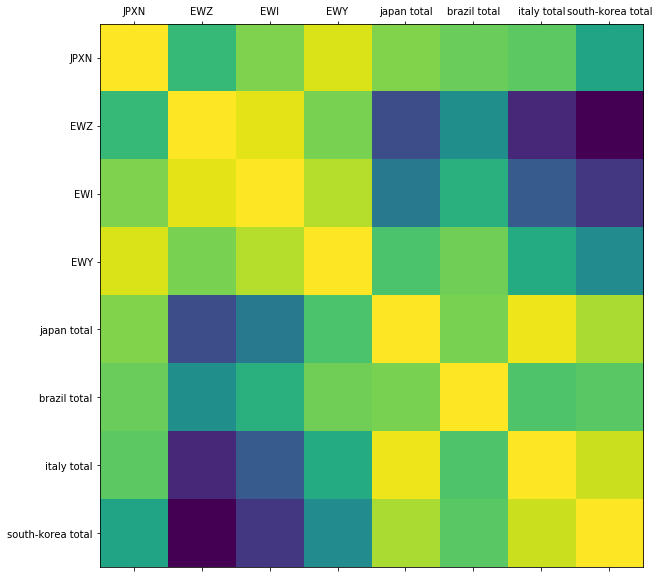

In [12]:
#Covid Total against Stock Price
plotCorrelation(covidTotalAndStockPrice,10)

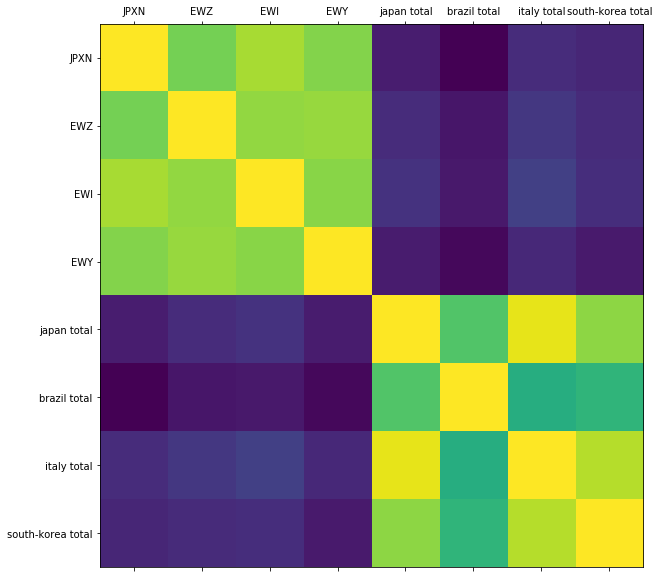

In [13]:
#Covid Total against Stock Price
plotCorrelation(covidTotalAndStockChange,10)

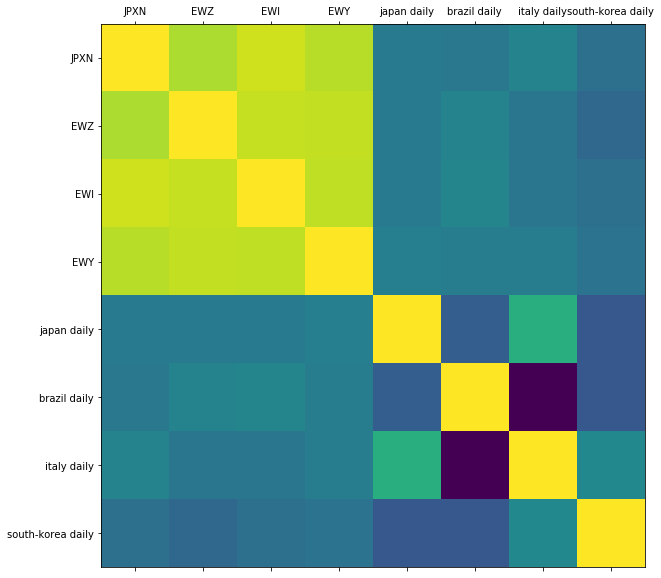

In [14]:
#COVID Cases Daily against Daily Stock Price Change
plotCorrelation(covidChangeAndStockChange, 10)

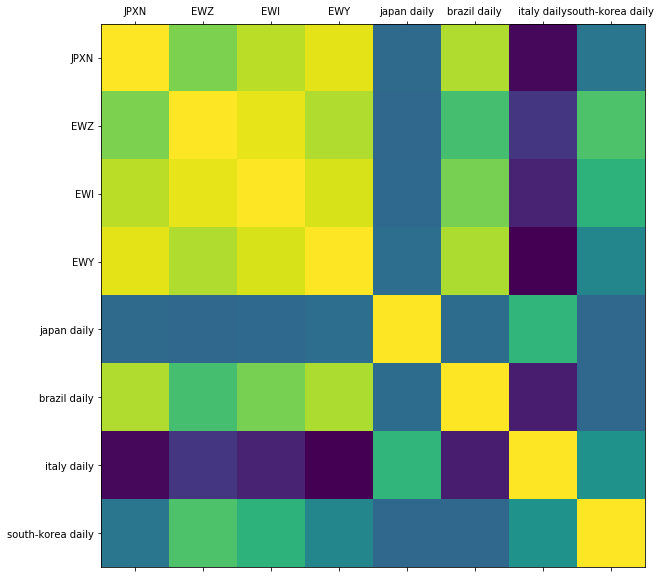

In [15]:
#COVID Cases Daily against Stock Price
plotCorrelation(covidChangeAndStockPrice,10)

In [143]:
covidChangeAndStockChange.corr()

,JPXN,EWZ,EWI,EWY,japan daily,brazil daily,italy daily,south-korea daily
JPXN,1.000000,0.790946,0.879112,0.816986,-0.005420,-0.026574,0.052727,-0.081654
EWZ,0.790946,1.000000,0.849655,0.844321,-0.001843,0.051838,-0.040840,-0.144600
EWI,0.879112,0.849655,1.000000,0.834314,-0.008680,0.067801,-0.038723,-0.082339
EWY,0.816986,0.844321,0.834314,1.000000,0.025693,0.012970,0.012779,-0.064629
japan daily,-0.005420,-0.001843,-0.008680,0.025693,1.000000,-0.203369,0.365740,-0.241096
brazil daily,-0.026574,0.051838,0.067801,0.012970,-0.203369,1.000000,-0.714652,-0.242141
italy daily,0.052727,-0.040840,-0.038723,0.012779,0.365740,-0.714652,1.000000,0.084692
south-korea daily,-0.081654,-0.144600,-0.082339,-0.064629,-0.241096,-0.242141,0.084692,1.000000


In [144]:
covidChangeAndStockPrice.corr()

,JPXN,EWZ,EWI,EWY,japan daily,brazil daily,italy daily,south-korea daily
JPXN,1.000000,0.631760,0.806229,0.923173,-0.222285,0.775433,-0.826947,-0.136375
EWZ,0.631760,1.000000,0.933334,0.778776,-0.236480,0.451616,-0.573638,0.479931
EWI,0.806229,0.933334,1.000000,0.890307,-0.230898,0.620769,-0.678804,0.338710
EWY,0.923173,0.778776,0.890307,1.000000,-0.189848,0.768415,-0.865920,-0.008592
japan daily,-0.222285,-0.236480,-0.230898,-0.189848,1.000000,-0.203369,0.365740,-0.241096
brazil daily,0.775433,0.451616,0.620769,0.768415,-0.203369,1.000000,-0.714652,-0.242141
italy daily,-0.826947,-0.573638,-0.678804,-0.865920,0.365740,-0.714652,1.000000,0.084692
south-korea daily,-0.136375,0.479931,0.338710,-0.008592,-0.241096,-0.242141,0.084692,1.000000


In [145]:
covidTotalAndStockChange.corr()

,JPXN,EWZ,EWI,EWY,japan total,brazil total,italy total,south-korea total
JPXN,1.000000,0.789167,0.870043,0.815565,0.079011,-0.001820,0.126099,0.105099
EWZ,0.789167,1.000000,0.838358,0.846737,0.126242,0.057016,0.161120,0.121805
EWI,0.870043,0.838358,1.000000,0.823121,0.144570,0.068031,0.186493,0.130553
EWY,0.815565,0.846737,0.823121,1.000000,0.073438,0.020591,0.115193,0.071258
japan total,0.079011,0.126242,0.144570,0.073438,1.000000,0.727856,0.963883,0.828287
brazil total,-0.001820,0.057016,0.068031,0.020591,0.727856,1.000000,0.623079,0.653157
italy total,0.126099,0.161120,0.186493,0.115193,0.963883,0.623079,1.000000,0.890148
south-korea total,0.105099,0.121805,0.130553,0.071258,0.828287,0.653157,0.890148,1.000000


In [146]:
covidTotalAndStockPrice.corr()

,JPXN,EWZ,EWI,EWY,japan total,brazil total,italy total,south-korea total
JPXN,1.000000,0.552446,0.735862,0.920883,0.740265,0.686633,0.655274,0.433280
EWZ,0.552446,1.000000,0.944759,0.725097,-0.042201,0.316279,-0.213119,-0.363528
EWI,0.735862,0.944759,1.000000,0.848678,0.185409,0.503589,0.030214,-0.144506
EWY,0.920883,0.725097,0.848678,1.000000,0.614569,0.706737,0.473208,0.294714
japan total,0.740265,-0.042201,0.185409,0.614569,1.000000,0.727856,0.963883,0.828287
brazil total,0.686633,0.316279,0.503589,0.706737,0.727856,1.000000,0.623079,0.653157
italy total,0.655274,-0.213119,0.030214,0.473208,0.963883,0.623079,1.000000,0.890148
south-korea total,0.433280,-0.363528,-0.144506,0.294714,0.828287,0.653157,0.890148,1.000000
